In [226]:
from PIL import Image
import numpy as np
import pandas as pd
import os
print(os.listdir(".\input"))

['usps.h5']


In [227]:
import h5py 
from functools import reduce

def getUspDataSet(path):
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        x_Train = train.get("data")[:]
        y_Train = train.get("target")[:]
        test = hf.get('test')
        x_Test = test.get("data")[:]
        y_Test = test.get("target")[:]
    return x_Train, y_Train, x_Test, y_Test

In [228]:
import matplotlib.pyplot as plt

def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary')
    plt.show()

In [229]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,
                                  prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images.iloc[idx, np.arange(0, 256)].as_matrix().reshape([16, 16]), cmap='binary')
        title= "label=" +str(labels.iloc[idx,0])
        if len(prediction)>0:
            title+=",predict="+str(prediction.iloc[idx,0]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [230]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

In [231]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [232]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

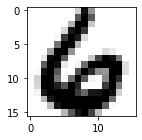

In [233]:
plot_image(x_Train_data.iloc[0, np.arange(0, 256)].as_matrix().reshape([16, 16]))

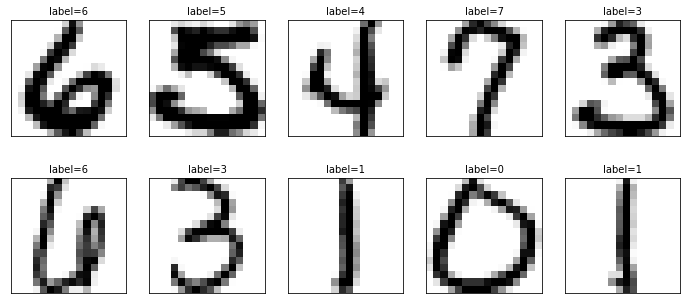

In [234]:
plot_images_labels_prediction(x_Train_data.loc[:,np.arange(0, 256)], x_Train_data.loc[:,['digital']],[],0,)

In [235]:
feature_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Total'])

table = np.zeros((2, 11))

for i in range(11):
    table[0][i] = x_Train_data[x_Train_data['digital'] == i].shape[0]
    table[1][i] = x_Test_data[x_Test_data['digital'] == i].shape[0]
    if i == 10:
        table[0][i] = x_Train_data.shape[0]
        table[1][i] = x_Test_data.shape[0]

pd.DataFrame(table, columns=feature_names)

0       1      2      3      4      5      6      7      8      9  \
0  1194.0  1005.0  731.0  658.0  652.0  556.0  664.0  645.0  542.0  644.0   
1   359.0   264.0  198.0  166.0  200.0  160.0  170.0  147.0  166.0  177.0   

    Total  
0  7291.0  
1  2007.0

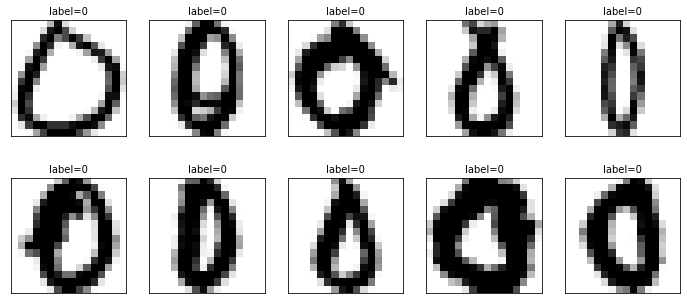

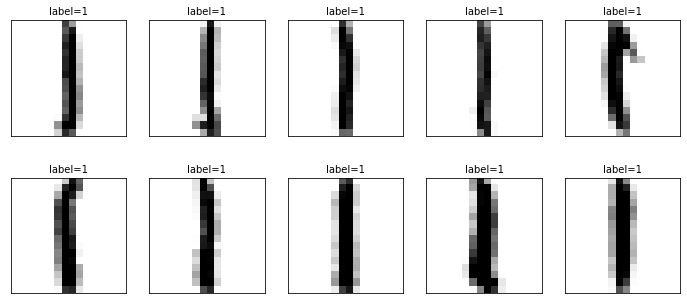

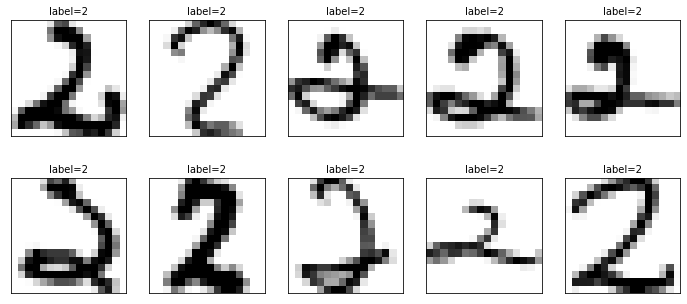

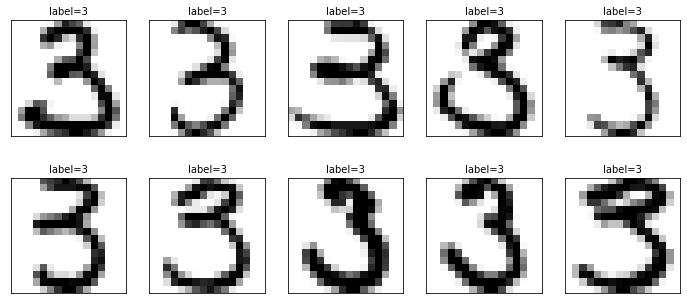

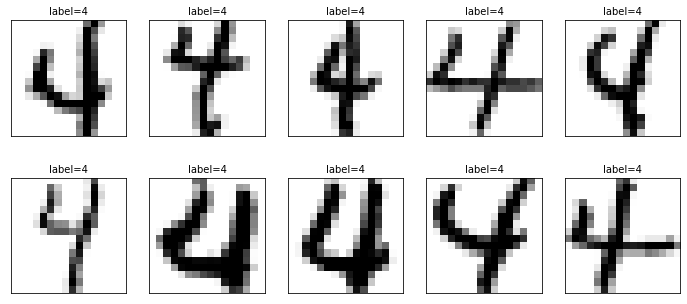

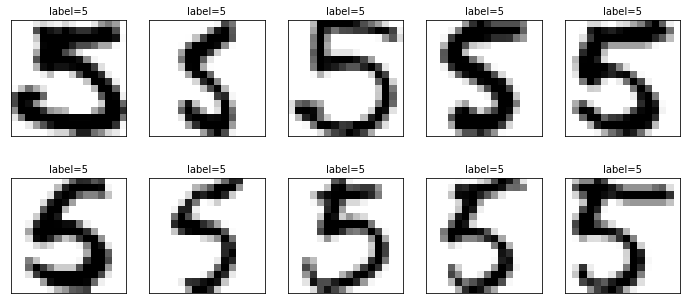

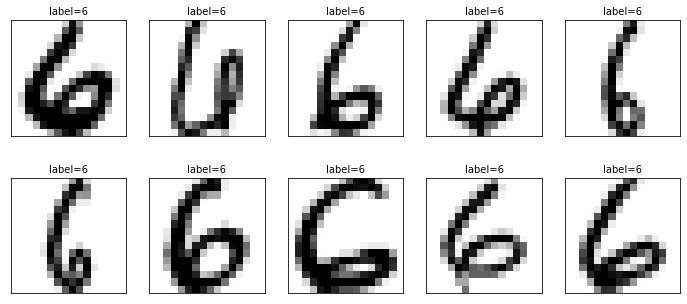

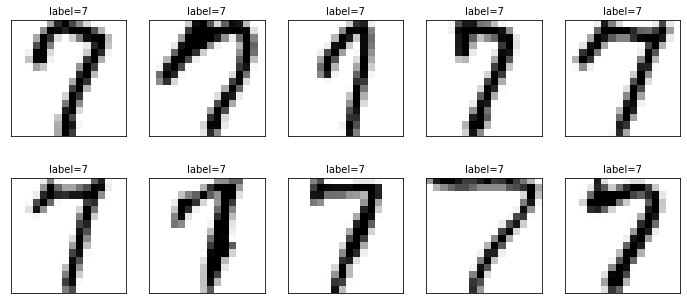

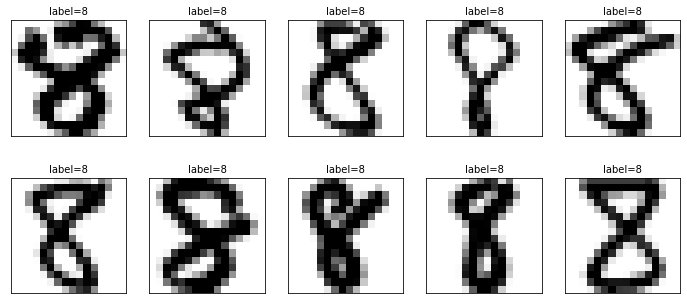

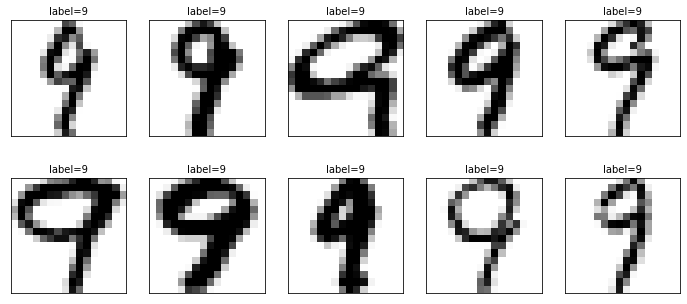

In [236]:
for i in range(0,10):
    plot_images_labels_prediction(x_Train_data[x_Train_data['digital'] == i].loc[:,np.arange(0, 256)], x_Train_data[x_Train_data['digital'] == i].loc[:,['digital']],[],0,)

# Handwritten Digits and a Simple Algorithm

### 透過 training set 取得手寫數字0~9的平均值陣列
### 將 testing set 每一張手寫數字與0~9平均值陣列比對，取最小的2norm，預測該張手寫數字代表的數字

In [237]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [238]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

In [239]:
def getMeanDigitalTable(x_Data, y_Data):

    x_Date_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['digital'])], axis=1)
    meanDigitalTable = np.zeros((10, 257))

    for i in range(10):
        for j in range(257):       
            if j == 256:
                meanDigitalTable[i][j] = int(i)
            else:
                meanDigitalTable[i][j] = x_Date_list[x_Date_list['digital'] == i].loc[:,np.arange(0, 256)].mean(axis = 0)[j]

    x_Train_mean = pd.DataFrame(meanDigitalTable, columns=np.arange(0, 257))

    return x_Train_mean

In [240]:
x_Train_mean = getMeanDigitalTable(x_Train, y_Train)

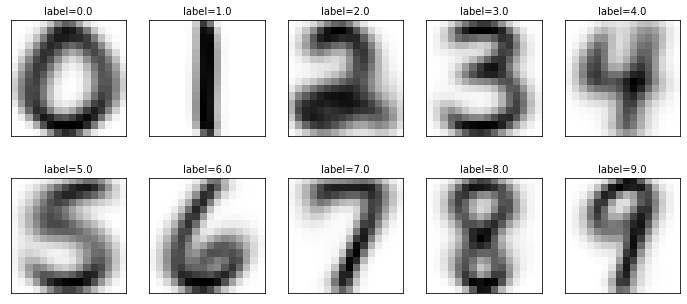

In [241]:
plot_images_labels_prediction(x_Train_mean.loc[:,np.arange(0, 256)], x_Train_mean.loc[:,[256]],[],0,10)

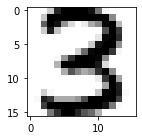

In [242]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

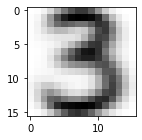

In [243]:
plot_image(x_Train_mean.iloc[3, np.arange(0, 256)].as_matrix().reshape([16, 16]))

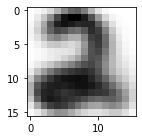

In [244]:
plot_image(x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

In [245]:
norm2(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

5.097931406215535

In [246]:
def simpleAlgorithm(x_Test_data, x_Train_mean):

    total = x_Test_data.shape[0]
    isSuccess = 0
    isError = 0
    result = np.zeros((total, 1))
    result_residual = np.zeros(total)
    result_residual_list = []

    for i in range(0, total):

        normList = np.zeros((1, 10))

        for j in range(0,10):
            residual_list = np.ones((10))

            normValue = norm2(x_Test_data.iloc[i, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[j, np.arange(0, 256)].as_matrix().reshape([16, 16]))
            normList[0][j] = normValue

        prediction = np.where(normList == np.amin(normList))

        result[i][0] = int(prediction[1])
        
        result_residual[i] = np.amin(normList)

        result_residual_list.append(normList[0])

    tempPd = pd.concat([x_Test_data, pd.DataFrame(result, columns=['prediction'])], axis=1)
    x_Test_Prediction = pd.concat([tempPd, pd.DataFrame(result_residual, columns=['residual'])], axis=1)
    
    x_Test_result = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].shape[0]/x_Test_Prediction.shape[0]

    return x_Test_Prediction, x_Test_result, result_residual_list

In [247]:
x_Test_Prediction, x_Test_result, result_Test_residual = simpleAlgorithm(x_Test_data, x_Train_mean)

In [255]:
x_Test_Prediction[x_Test_Prediction['prediction'] != x_Test_Prediction['digital']].shape

(448, 259)

In [249]:
print("準確率為 :", x_Test_result)

準確率為 : 0.7767812655705032


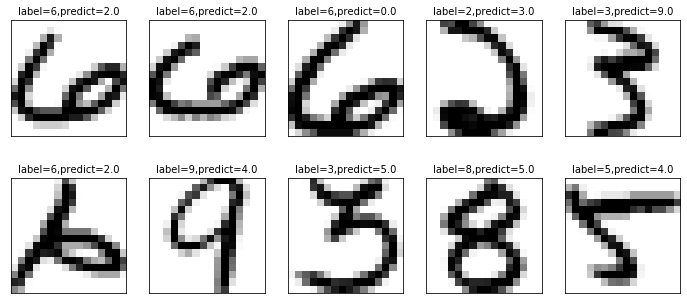

In [250]:
errorList = x_Test_Prediction[x_Test_Prediction['digital'] != x_Test_Prediction['prediction']]

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [251]:
totalCounts = x_Test_Prediction[['digital']].groupby(['digital']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('digital', ascending=[True])
errorCounts = errorList[['digital']].groupby(['digital']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('digital', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

digital  totalCounts  errorCounts  successCounts  probability
5        5          160           53            107     0.668750
2        2          198           63            135     0.681818
8        8          166           52            114     0.686747
3        3          166           50            116     0.698795
4        4          200           58            142     0.710000
9        9          177           35            142     0.802260
7        7          147           29            118     0.802721
6        6          170           33            137     0.805882
0        0          359           63            296     0.824513
1        1          264           12            252     0.954545

In [252]:
temp = errorList[['digital', 'prediction']].groupby(['digital', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1     2     3     4     5     6     7     8     9
0   6.0  6.0   4.0   5.0   9.0   3.0   0.0   9.0   5.0   4.0
1  35.0  3.0  16.0  21.0  31.0  17.0  10.0  13.0  15.0  15.0
2   5.0  9.0   3.0   0.0   2.0   0.0   5.0   4.0   2.0   8.0
3   8.0  3.0  13.0   9.0   9.0  12.0   9.0   6.0   9.0   8.0

In [253]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

x_Test_0_data = pd.concat([pd.DataFrame(x_Test_0),pd.DataFrame(y_Test_0, columns=['digital'])], axis=1)
result_Test_0_list, y_Test_0_predict, result_Test_0_residual = simpleAlgorithm(x_Test_0_data, x_Train_mean)

In [254]:
y_Test_0_predict

0.8245125348189415

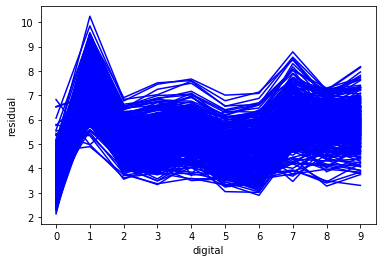

In [256]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [257]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

x_Test_1_data = pd.concat([pd.DataFrame(x_Test_1),pd.DataFrame(y_Test_1, columns=['digital'])], axis=1)
result_Test_1_list, y_Test_1_predict, result_Test_1_residual = simpleAlgorithm(x_Test_1_data, x_Train_mean)

In [258]:
y_Test_1_predict

0.9545454545454546

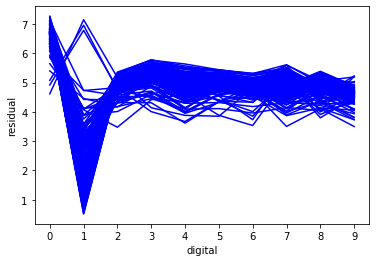

In [259]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [260]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

x_Test_2_data = pd.concat([pd.DataFrame(x_Test_2),pd.DataFrame(y_Test_2, columns=['digital'])], axis=1)
result_Test_2_list, y_Test_2_predict, result_Test_2_residual = simpleAlgorithm(x_Test_2_data, x_Train_mean)

In [261]:
y_Test_2_predict

0.6818181818181818

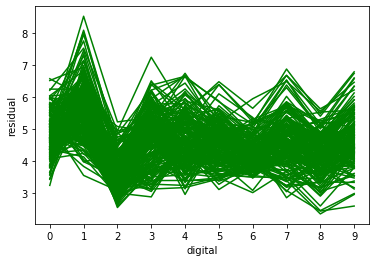

In [262]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'green')

In [263]:
components = np.where(y_Test == 5)[0]
components
x_Test_5 = x_Test[components, :]
y_Test_5 = np.full(x_Test_5.shape[0],5)

x_Test_5_data = pd.concat([pd.DataFrame(x_Test_5),pd.DataFrame(y_Test_5, columns=['digital'])], axis=1)
result_Test_5_list, y_Test_5_predict, result_Test_5_residual = simpleAlgorithm(x_Test_5_data, x_Train_mean)

In [264]:
y_Test_5_predict

0.66875

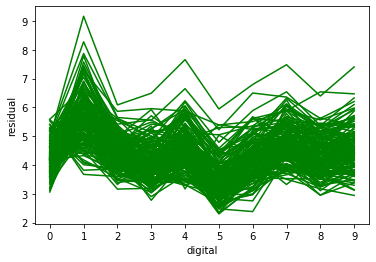

In [265]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_5.shape[0]):
    plt.plot(result_Test_5_residual[i],color = 'green')

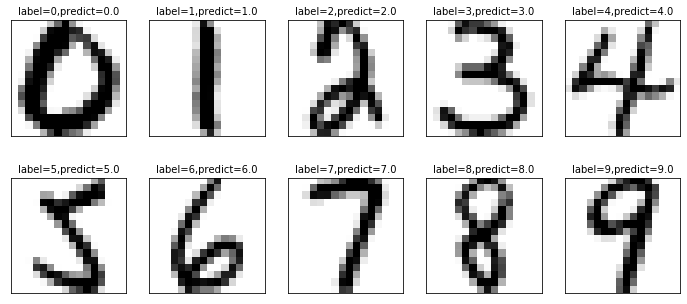

In [266]:
minList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

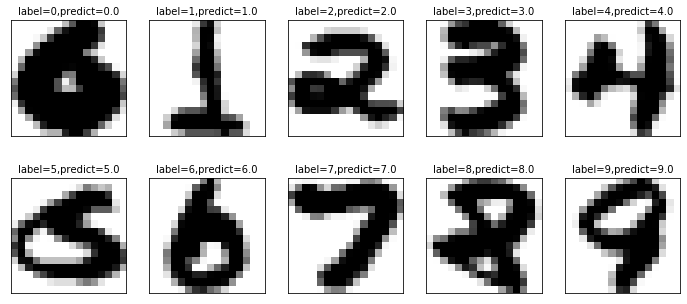

In [267]:
maxList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [268]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [269]:
x_Teacher_data = pd.concat([pd.DataFrame(x_Teacher),pd.DataFrame(y_Teacher, columns=['digital'])], axis=1)

In [270]:
x_Teacher_Prediction, x_Teacher_result, result_Teacher_residual = simpleAlgorithm(x_Teacher_data, x_Train_mean)
x_Teacher_result

0.5

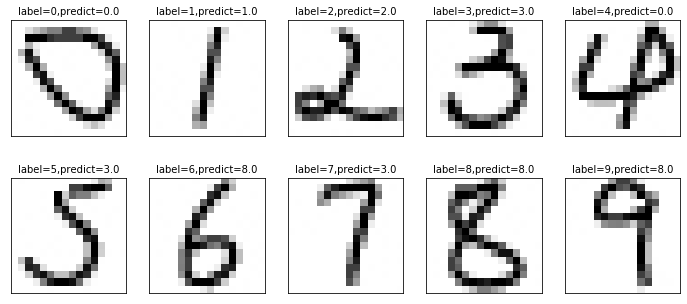

In [271]:
plot_images_labels_prediction(x_Teacher_Prediction.iloc[:,np.arange(0, 256)], x_Teacher_Prediction.iloc[:,[256]], x_Teacher_Prediction.iloc[:,[257]],0,10)

In [272]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [273]:
x_Student_data = pd.concat([pd.DataFrame(x_Student),pd.DataFrame(y_Student, columns=['digital'])], axis=1)

In [274]:
x_Student_Prediction, x_Student_result, result_Student_residual = simpleAlgorithm(x_Student_data, x_Train_mean)
x_Student_result

0.4

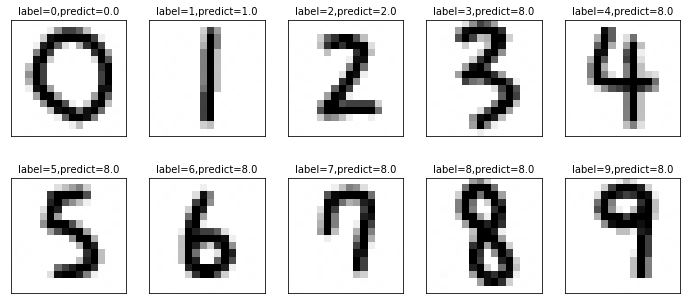

In [275]:
plot_images_labels_prediction(x_Student_Prediction.iloc[:,np.arange(0, 256)], x_Student_Prediction.iloc[:,[256]], x_Student_Prediction.iloc[:,[257]],0,10)

# Classification Using SVD Bases

In [276]:
def getUList(x_Data, y_Data):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T
    
    #  we now partition the x_train based on the ten classes and store in a list.

    x_list = []

    for k in range(10):
        components = np.where(y_Data == k)[0]
        x_list.append(x_Data[:, components])

    # we now create a svd basis for each digit data samples.

    U_list = []

    for k in range(10):
        U, S, V = np.linalg.svd(x_list[k])
        U_list.append(U)
    
    return U_list


def svdAlgorithm (x_Data, y_Data, U_list,basis):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T

    # we now select the dominant orthogonal basis and project the digits on the reduced basis to compute the least square projection error.

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[1]
        y_predict = np.ones(n_Data)
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            z = x_Data[:, i]
            residual_list = np.ones(10)
            
            for j in range(10):
                U_k = U_list[j][:, :r+1]
                residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
                residual_list[j] = residual

            y_predict[i] = np.argmin(residual_list)
            
            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))
    
    x_Data_list = pd.concat([pd.DataFrame(x_Data.T),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_List = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_List = pd.concat([result_List, pd.DataFrame(result_single, columns=['residual'])], axis=1)

    result_predict = result_List[result_List['actual'] == result_List['prediction']].shape[0]/result_List.shape[0]

    return result_List, y_predict, result_predict, result_residual, result_mse

In [277]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [278]:
U_list = getUList(x_Train, y_Train)

In [279]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = svdAlgorithm(x_Train, y_Train, U_list, 10)

In [280]:
result_Train_predict

0.9680427924838843

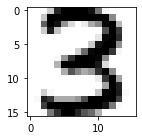

In [281]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))
z = x_Test_data.iloc[2, np.arange(0, 256)]

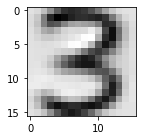

0.2509679228624524

In [282]:
U_k = U_list[3][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

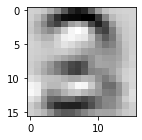

0.49734799699082527

In [283]:
U_k = U_list[2][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

In [325]:
result_Train_list[result_Train_list['prediction'] != result_Train_list['actual']].shape

(233, 259)

In [285]:
result_Train_residual[7290]

array([0.62684596, 0.1769527 , 0.55635041, 0.63328332, 0.39543733,
       0.61783707, 0.55588669, 0.56893593, 0.35287929, 0.48034778])

In [286]:
result_Train_mse

[3.198052393361679,
 1.4978740913454944,
 1.2891235770127554,
 0.9462350843505692,
 0.7939925936085585,
 0.7944040597997531,
 0.7104649567960499,
 0.5841448360993005,
 0.5739953367164998,
 0.5336716499794267]

Text(0.5, 0, 'number of basis')

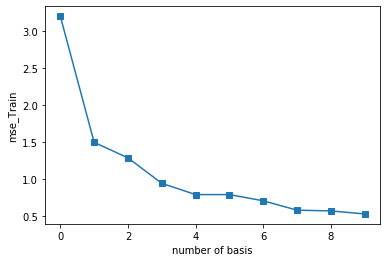

In [287]:
plt.plot(result_Train_mse,'s-')
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [288]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = svdAlgorithm(x_Test, y_Test, U_list, 20)

In [289]:
result_Test_predict

0.9412057797708022

In [328]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']].shape

(118, 259)

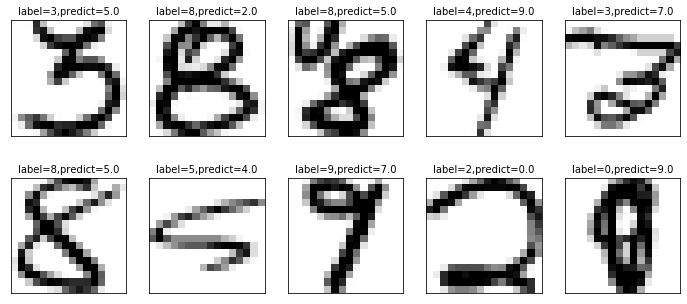

In [291]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [292]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1    2     3    4    5    6    7    8    9
0  1.0  4.0  0.0   5.0  9.0  0.0  5.0  4.0  3.0  4.0
1  2.0  3.0  8.0  13.0  5.0  5.0  4.0  3.0  4.0  4.0
2  2.0  6.0  4.0   2.0  1.0  8.0  4.0  1.0  0.0  1.0
3  2.0  2.0  5.0   3.0  3.0  3.0  1.0  1.0  3.0  2.0

In [293]:
totalCounts = result_Test_list[['actual']].groupby(['actual']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('actual', ascending=[True])
errorCounts = errorList[['actual']].groupby(['actual']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('actual', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

actual  totalCounts  errorCounts  successCounts  probability
3       3          166           22            144     0.867470
8       8          166           16            150     0.903614
5       5          160           15            145     0.906250
2       2          198           18            180     0.909091
4       4          200           15            185     0.925000
9       9          177            9            168     0.949153
7       7          147            6            141     0.959184
6       6          170            5            165     0.970588
0       0          359            7            352     0.980501
1       1          264            5            259     0.981061

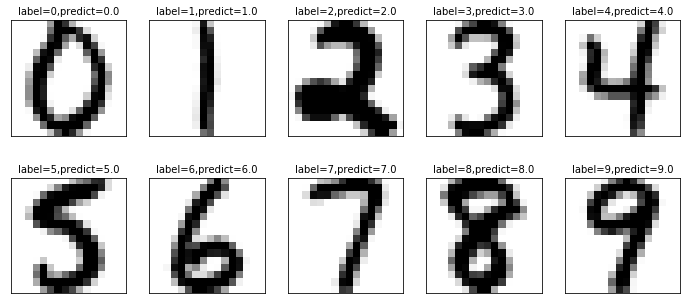

In [294]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

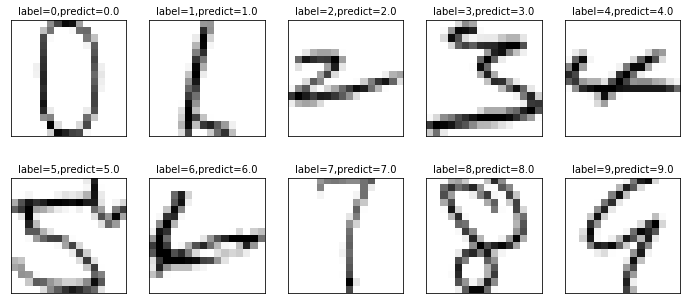

In [295]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [296]:
result_Test_residual[2006]

array([0.66521549, 0.06187747, 0.65652156, 0.6250729 , 0.3532581 ,
       0.63854527, 0.42578962, 0.51065224, 0.45140523, 0.51292944])

In [297]:
result_Test_mse

[4.022421524663677,
 2.0269058295964126,
 1.8256103637269556,
 1.4867962132536123,
 1.2227204783258594,
 1.2825112107623318,
 1.1629297458893872,
 1.1031390134529149,
 1.0488290981564523,
 0.9725959142999502,
 0.9785749875435974,
 0.9237668161434978,
 0.9182859990034878,
 0.9157947184853015,
 0.9088191330343797,
 0.8629795714997509,
 0.9466865969108121,
 0.9387144992526159,
 0.9103139013452914,
 0.8809167912306926]

Text(0.5, 0, 'number of basis')

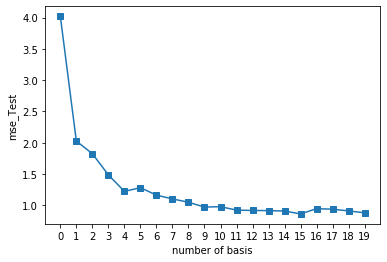

In [298]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,20))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [299]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

In [300]:
result_Test_0_list, y_Test_0_predict, result_Test_0_predict, result_Test_0_residual, result_Test_0_mse = svdAlgorithm(x_Test_0, y_Test_0, U_list, 20)

In [301]:
result_Test_0_predict

0.9805013927576601

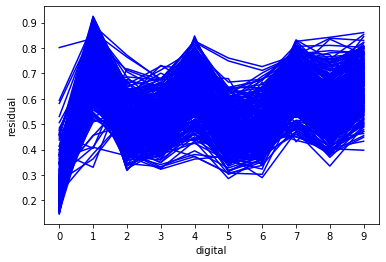

In [302]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [303]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

In [304]:
result_Test_1_list, y_Test_1_predict, result_Test_1_predict, result_Test_1_residual, result_Test_1_mse = svdAlgorithm(x_Test_1, y_Test_1, U_list, 20)

In [305]:
result_Test_1_predict

0.9810606060606061

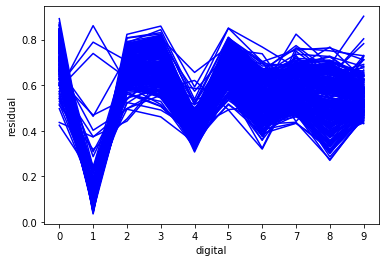

In [306]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [307]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [308]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = svdAlgorithm(x_Test_3, y_Test_3, U_list, 20)

In [309]:
result_Test_3_predict

0.8674698795180723

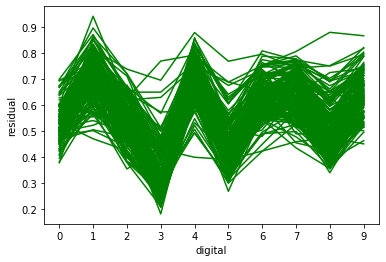

In [310]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'green')

In [311]:
components = np.where(y_Test == 8)[0]
components
x_Test_8 = x_Test[components, :]
y_Test_8 = np.full(x_Test_8.shape[0],8)

In [312]:
result_Test_8_list, y_Test_8_predict, result_Test_8_predict, result_Test_8_residual, result_Test_8_mse = svdAlgorithm(x_Test_8, y_Test_8, U_list, 20)

In [313]:
result_Test_8_predict

0.9036144578313253

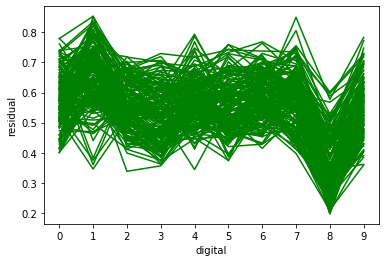

In [314]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_8.shape[0]):
    plt.plot(result_Test_8_residual[i], color = 'green')

In [315]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [316]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = svdAlgorithm(x_Teacher, y_Teacher, U_list, 10)
result_Teacher_predict

0.8

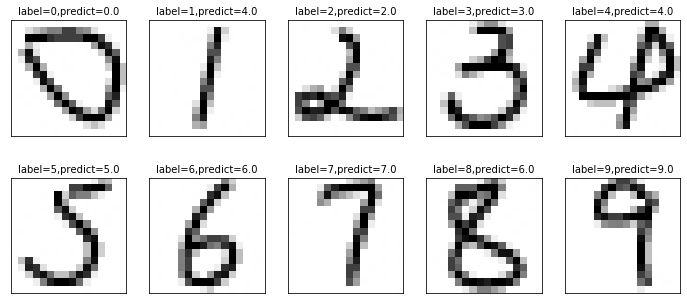

In [317]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [318]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [319]:
result_Student_list, y_Student_predict, result_Student_predict, result_Student_residual, result_Student_mse = svdAlgorithm(x_Student, y_Student, U_list, 10)
result_Student_predict

0.9

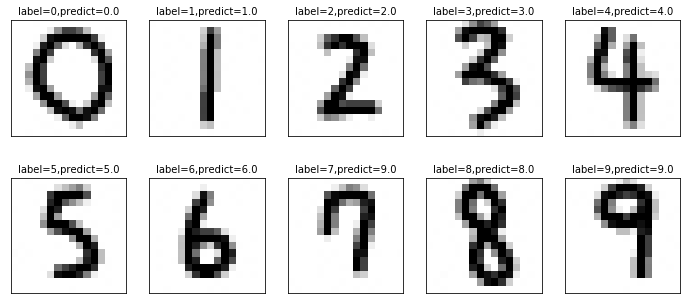

In [320]:
plot_images_labels_prediction(result_Student_list.iloc[:,np.arange(0, 256)], result_Student_list.iloc[:,[256]], result_Student_list.iloc[:,[257]],0,10)

# Classification Using higher order SVD (HOSVD)

In [321]:
import numpy as np
import torch as tc
import tensorly as tl
from tensorly.decomposition import tucker 

from sktensor import dtensor
from sktensor.tucker import hooi

def getSandUList(X_Date):
    X_Date = X_Date.astype('float32') / 255.
    X_Date = X_Date.reshape((len(X_Date), np.prod(X_Date.shape[1:])))

    x_list = []

    for k in range(10):
        components = np.where(y_Train == k)[0]
        x_list.append(x_Train[components, :])

    S_list = []
    U_list = []

    for k in range(10):

        tensor = np.zeros((16, 16, x_list[k].shape[0]))

        for i in range(x_list[k].shape[0]):
            tensor[:,:,i] = x_list[k][i][:].reshape([16, 16])

        A = dtensor(tensor)
        S, U = hooi(A, A.shape, init='nvecs')

        S_list.append(S)
        U_list.append(U)
    
    return S_list, U_list

def hosvdAlgorithm (x_Data, y_Data, S_list, U_list, basis):

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[0]
        y_predict = np.ones((n_Data))
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            Z = x_Data[i][:].reshape([16, 16])
            residual_list = np.ones((10))

            for d in range(10):
                U1, U2, U3 = U_list[d]
                S = S_list[d]
                
                Sigma = np.zeros((16, 16))

                for j in range(r+1):
                    Aj = U1.dot(S[:,:,j]).dot(U2.T)
                    Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
                    Sigma = Sigma + (Cj*Aj)

                G = np.linalg.norm(Z-Sigma, 2)

                residual_list[d] = G

            y_predict[i] = np.argmin(residual_list)

            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))

    x_Data_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_list = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_list = pd.concat([result_list, pd.DataFrame(result_single, columns=['residual'])], axis=1)
    result_prediction = result_list[result_list['prediction'] == result_list['actual']].shape[0]/result_list.shape[0]

    return result_list, y_predict, result_prediction, result_residual, result_mse

In [322]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


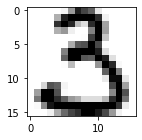

In [323]:
x_Train.shape
plot_image(x_Train[4][:].reshape([16, 16]))

In [324]:
components = np.where(y_Train == 3)[0]
components
x_Train_3 = x_Train[components, :]
y_Train_3 = np.full(x_Train_3.shape[0],3)

x_Train_3.shape

(658, 256)

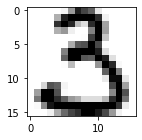

In [326]:
tensor = np.zeros((16, 16, x_Train_3.shape[0]))

for i in range(x_Train_3.shape[0]):
    tensor[:,:,i] = x_Train_3[i][:].reshape([16, 16])

plot_image(tensor[:,:,0])

In [327]:
A = dtensor(tensor)
S, U = hooi(A, A.shape, init='nvecs')

In [329]:
S.shape, U[0].shape, U[1].shape, U[2].shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

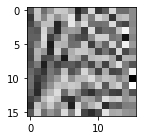

In [330]:
plot_image(U[0])

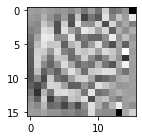

In [331]:
plot_image(U[1])

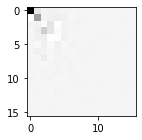

In [332]:
plot_image(S[:,:,0])

In [333]:
A_hosvd = tc.einsum("abc,da,eb,fc->def", tc.as_tensor(S), tc.as_tensor(U[0]), tc.as_tensor(U[1]), tc.as_tensor(U[2]))

In [334]:
hosvd_tensor = tc.Tensor.cpu(A_hosvd).detach().numpy()[:,:,:]

In [335]:
tensor.shape, hosvd_tensor.shape

((16, 16, 658), (16, 16, 658))

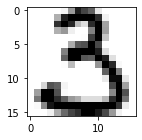

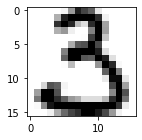

In [336]:
plot_image(tensor[:,:,0])
plot_image(hosvd_tensor[:,:,0])

In [337]:
error = np.linalg.norm(tensor - hosvd_tensor)
error

7.951257058125007e-13

In [338]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [339]:
S_list, U_list = getSandUList(x_Train)

In [340]:
U1, U2, U3 = U_list[3]
S = S_list[3]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

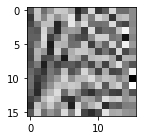

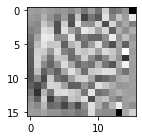

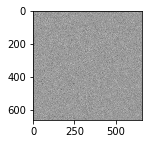

In [341]:
plot_image(U1)
plot_image(U2)
plot_image(U3)

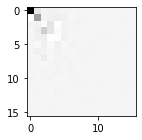

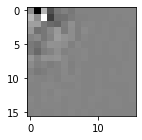

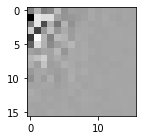

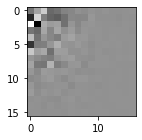

In [342]:
plot_image(S[:,:,0])
plot_image(S[:,:,1])
plot_image(S[:,:,2])
plot_image(S[:,:,3])

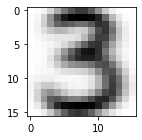

In [343]:
Aj = U1.dot(S[:,:,0]).dot(U2.T)
plot_image(Aj)

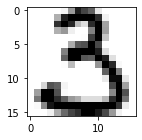

In [344]:
Z = x_Train[4][:].reshape([16, 16])
plot_image(Z)

In [345]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.04179627116659144

In [346]:
G = np.linalg.norm(Z-Cj*Aj, 2)
G

2.5013599861892444

In [347]:
U1, U2, U3 = U_list[2]
S = S_list[2]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 731), (16, 16), (16, 16), (731, 731))

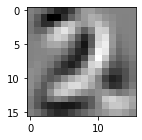

In [348]:
Aj = U1.dot(S[:,:,3]).dot(U2.T)
plot_image(Aj)

In [349]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.03371456395196703

In [350]:
G = np.linalg.norm(Z-Cj*Aj, 2)
G

6.0779136949076555

In [351]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = hosvdAlgorithm(x_Train, y_Train, S_list, U_list, 4)

In [352]:
result_Train_predict

0.920175558908243

In [353]:
result_Train_residual[7290]

array([0.02027895, 0.00790079, 0.0174685 , 0.01878735, 0.01523847,
       0.018218  , 0.01498122, 0.017311  , 0.01310196, 0.01200696])

In [354]:
result_Train_mse

[3.587710876422987, 1.986970237278837, 1.4770264709916334, 1.2575778356878342]

Text(0.5, 0, 'number of basis')

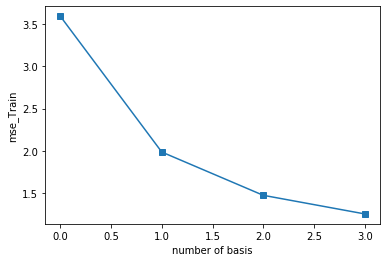

In [355]:
plt.plot(result_Train_mse,'s-')
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [356]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = hosvdAlgorithm(x_Test, y_Test, S_list, U_list, 10)

In [357]:
result_Test_predict

0.9157947184853015

In [358]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']].shape

(169, 259)

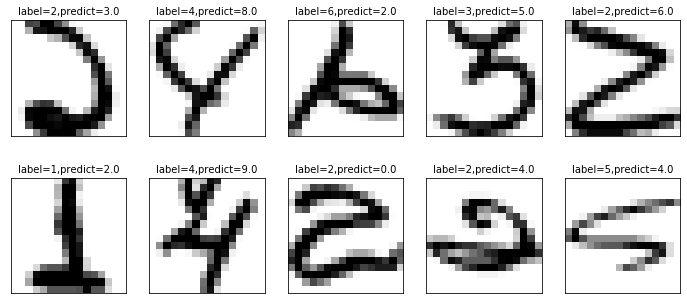

In [359]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [360]:
totalCounts = result_Test_list[['actual']].groupby(['actual']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('actual', ascending=[True])
errorCounts = errorList[['actual']].groupby(['actual']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('actual', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

actual  totalCounts  errorCounts  successCounts  probability
3       3          166           31            135     0.813253
2       2          198           28            170     0.858586
5       5          160           19            141     0.881250
8       8          166           18            148     0.891566
7       7          147           14            133     0.904762
4       4          200           19            181     0.905000
9       9          177           11            166     0.937853
6       6          170            9            161     0.947059
0       0          359           12            347     0.966574
1       1          264            8            256     0.969697

In [361]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1     2     3    4    5    6    7    8    9
0  8.0  6.0   0.0   5.0  9.0  3.0  5.0  9.0  2.0  4.0
1  4.0  4.0  13.0  19.0  7.0  9.0  3.0  7.0  4.0  4.0
2  2.0  4.0   4.0   8.0  6.0  9.0  2.0  4.0  5.0  7.0
3  2.0  2.0   4.0   5.0  4.0  3.0  2.0  4.0  4.0  3.0

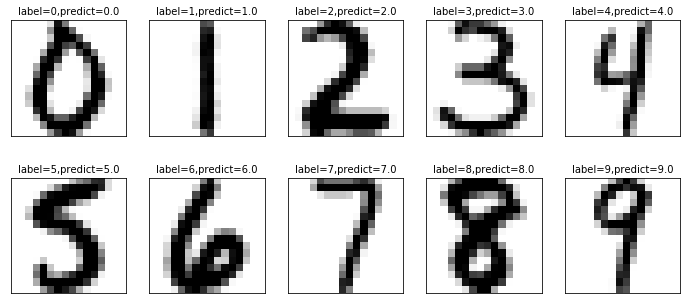

In [362]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

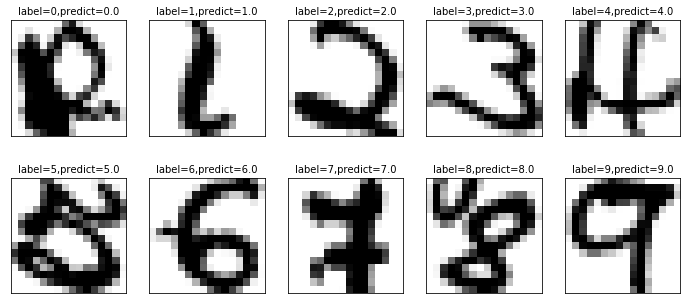

In [363]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [364]:
result_Test_residual[2006]

array([0.01892433, 0.00148868, 0.01481788, 0.01671563, 0.00819536,
       0.01475702, 0.011525  , 0.01439464, 0.01173524, 0.01012015])

In [365]:
result_Test_mse

[4.646238166417539,
 2.5112107623318387,
 2.1524663677130045,
 1.7404085700049825,
 1.5371200797209765,
 1.4349775784753362,
 1.3996013951170903,
 1.271549576482312,
 1.168410563029397,
 1.2386646736422522]

Text(0.5, 0, 'number of basis')

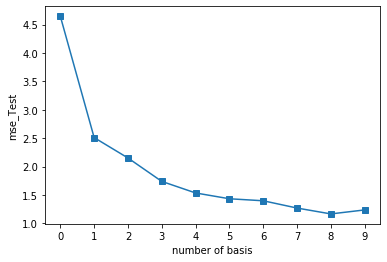

In [366]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,10))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [367]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

In [368]:
result_Test_0_list, y_Test_0_predict, result_Test_0_predict, result_Test_0_residual, result_Test_0_mse = hosvdAlgorithm(x_Test_0, y_Test_0, S_list, U_list, 10)

In [369]:
result_Test_0_predict

0.9665738161559888

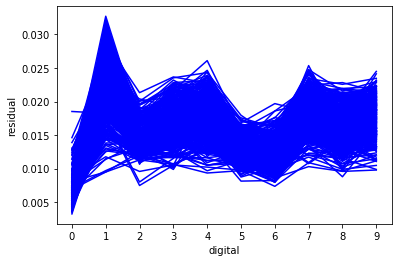

In [370]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [371]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

In [372]:
result_Test_1_list, y_Test_1_predict, result_Test_1_predict, result_Test_1_residual, result_Test_1_mse = hosvdAlgorithm(x_Test_1, y_Test_1, S_list, U_list, 10)

In [373]:
result_Test_1_predict

0.9696969696969697

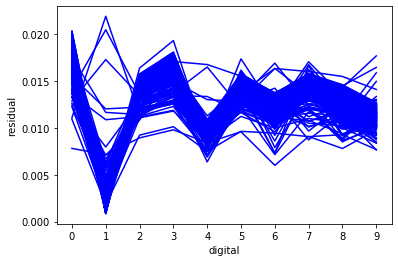

In [374]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [375]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

In [376]:
result_Test_2_list, y_Test_2_predict, result_Test_2_predict, result_Test_2_residual, result_Test_2_mse = hosvdAlgorithm(x_Test_2, y_Test_2, S_list, U_list, 10)

In [377]:
result_Test_2_predict

0.8585858585858586

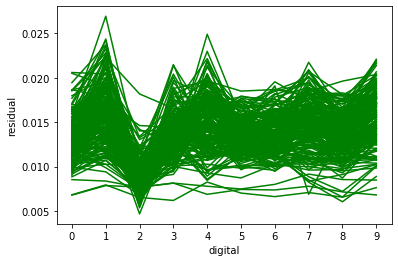

In [378]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'green')

In [379]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [380]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = hosvdAlgorithm(x_Test_3, y_Test_3, S_list, U_list, 10)

In [381]:
result_Test_3_predict

0.8132530120481928

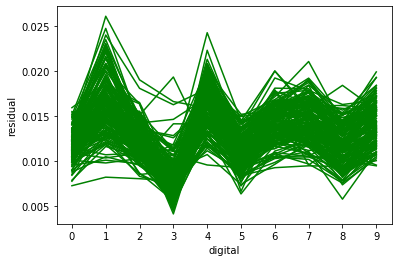

In [382]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'green')

In [383]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [384]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = hosvdAlgorithm(x_Teacher, y_Teacher, S_list, U_list, 10)
result_Teacher_predict

0.8

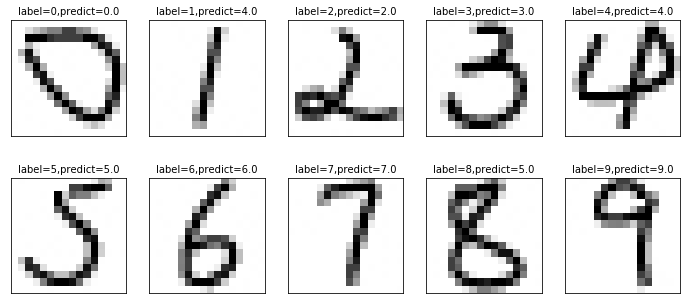

In [385]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [386]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [387]:
result_Student_list, y_Student_predict, result_Student_predict, result_Student_residual, result_Student_mse = hosvdAlgorithm(x_Student, y_Student, S_list, U_list, 10)
result_Student_predict

0.9

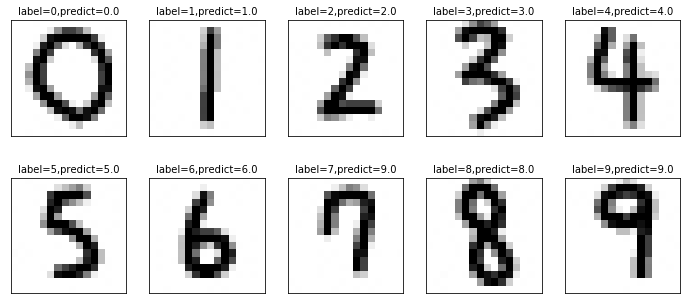

In [388]:
plot_images_labels_prediction(result_Student_list.iloc[:,np.arange(0, 256)], result_Student_list.iloc[:,[256]], result_Student_list.iloc[:,[257]],0,10)

# Classification Using Random Forest (隨機森林演算法)

In [389]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [390]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

In [391]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10,random_state=3,n_jobs=2)

In [392]:
forest.fit(x_Train,y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [393]:
y_Test_pred = forest.predict(x_Test)

In [394]:
prediction_data = pd.concat([pd.DataFrame(y_Test, columns=['actual']), pd.DataFrame(y_Test_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.916791230692576

In [395]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [396]:
y_Teacher_pred = forest.predict(x_Teacher)

In [397]:
prediction_data = pd.concat([pd.DataFrame(y_Teacher, columns=['actual']), pd.DataFrame(y_Teacher_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.8

In [398]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [399]:
y_Student_pred = forest.predict(x_Student)

In [400]:
prediction_data = pd.concat([pd.DataFrame(y_Student, columns=['actual']), pd.DataFrame(y_Student_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.7

# Classification Using MLP (多層感知器)

In [401]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

In [402]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [403]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [404]:
model = Sequential()
                
model.add(Dense(input_dim=256,
                units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=10,
                kernel_initializer='normal',
                activation='softmax'))

In [405]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 0s - loss: 1.4806 - accuracy: 0.6223 - val_loss: 0.6170 - val_accuracy: 0.8424
Epoch 2/20
20/20 - 0s - loss: 0.3995 - accuracy: 0.8896 - val_loss: 0.2817 - val_accuracy: 0.9082
Epoch 3/20
20/20 - 0s - loss: 0.2336 - accuracy: 0.9359 - val_loss: 0.2062 - val_accuracy: 0.9342
Epoch 4/20
20/20 - 0s - loss: 0.1829 - accuracy: 0.9491 - val_loss: 0.2050 - val_accuracy: 0.9349
Epoch 5/20
20/20 - 0s - loss: 0.1553 - accuracy: 0.9583 - val_loss: 0.1665 - val_accuracy: 0.9513
Epoch 6/20
20/20 - 0s - loss: 0.1326 - accuracy: 0.9630 - val_loss: 0.1587 - val_accuracy: 0.9527
Epoch 7/20
20/20 - 0s - loss: 0.1142 - accuracy: 0.9695 - val_loss: 0.1524 - val_accuracy: 0.9548
Epoch 8/20
20/20 - 0s - loss: 0.0982 - accuracy: 0.9741 - val_loss: 0.1463 - val_accuracy: 0.9520
Epoch 9/20
20/20 - 0s - loss: 0.0819 - accuracy: 0.9805 - val_loss: 0.1436 - val_accuracy: 0.9568
Epoch 10/20
20/20 - 0s - loss: 0.0711 - accuracy: 0.9823 - val_loss: 0.1259 - val_accuracy: 0.9630
Epoch 11/20
20/20 -

In [406]:
scores = model.evaluate(x_Test , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 5ms/step - loss: 0.3077 - accuracy: 0.9342


0.9342302083969116

In [407]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [408]:
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [409]:
scores = model.evaluate(x_Teacher , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 6ms/step - loss: 27.2577 - accuracy: 0.9000


0.8999999761581421

In [410]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [411]:
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [412]:
scores = model.evaluate(x_Student , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using CNN (卷積神經網路)

In [413]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils import np_utils

In [414]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [415]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [416]:
# 多加一個顏色的維度 
x_Train4D=x_Train_tensor.reshape(x_Train_tensor.shape[0],16,16,1).astype('float32')
x_Test4D=x_Test_tensor.reshape(x_Test_tensor.shape[0],16,16,1).astype('float32')

In [417]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [418]:
# define network structure

model = Sequential()

# initializing CNN

# 一個 Convolution Operation 搭配 一個 Pooling

# 二維卷積層 : filter為16, Kernel size為(5,5),Padding為(same)
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(16,16,1), 
                 activation='relu'))

# MaxPooling size為(2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer

model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Drop掉部分神經元避免overfitting
model.add(Dropout(0.25))

# 平坦化
model.add(Flatten())

# Fully Connected Networks

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))

In [419]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train4D, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 3s - loss: 1.7409 - accuracy: 0.4347 - val_loss: 0.7710 - val_accuracy: 0.8143
Epoch 2/20
20/20 - 4s - loss: 0.6365 - accuracy: 0.8030 - val_loss: 0.2804 - val_accuracy: 0.9157
Epoch 3/20
20/20 - 3s - loss: 0.3277 - accuracy: 0.8966 - val_loss: 0.1999 - val_accuracy: 0.9363
Epoch 4/20
20/20 - 3s - loss: 0.2510 - accuracy: 0.9244 - val_loss: 0.1541 - val_accuracy: 0.9520
Epoch 5/20
20/20 - 3s - loss: 0.2081 - accuracy: 0.9427 - val_loss: 0.1453 - val_accuracy: 0.9486
Epoch 6/20
20/20 - 4s - loss: 0.1772 - accuracy: 0.9496 - val_loss: 0.1174 - val_accuracy: 0.9589
Epoch 7/20
20/20 - 4s - loss: 0.1453 - accuracy: 0.9594 - val_loss: 0.0971 - val_accuracy: 0.9671
Epoch 8/20
20/20 - 3s - loss: 0.1296 - accuracy: 0.9630 - val_loss: 0.0893 - val_accuracy: 0.9692
Epoch 9/20
20/20 - 4s - loss: 0.1130 - accuracy: 0.9672 - val_loss: 0.0758 - val_accuracy: 0.9753
Epoch 10/20
20/20 - 4s - loss: 0.1057 - accuracy: 0.9688 - val_loss: 0.0720 - val_accuracy: 0.9726
Epoch 11/20
20/20 -

In [420]:
scores = model.evaluate(x_Test4D , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 7ms/step - loss: 0.1499 - accuracy: 0.9571


0.9571499824523926

In [421]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [422]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
x_Teacher4D=x_Teacher_tensor.reshape(x_Teacher_tensor.shape[0],16,16,1).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [423]:
scores = model.evaluate(x_Teacher4D , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 7ms/step - loss: 47.8662 - accuracy: 0.8000


0.800000011920929

In [424]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [425]:
x_Student_tensor = x_Student.reshape(len(x_Student), 16, 16).astype('float32')
x_Student4D=x_Student_tensor.reshape(x_Student_tensor.shape[0],16,16,1).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [426]:
scores = model.evaluate(x_Student4D , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using RNN (循環神經網路)

In [427]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN
from keras.utils import np_utils

In [428]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [429]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [430]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [431]:
# define network structure

model = Sequential()

model.add(SimpleRNN(input_shape=(16,16),
                    units = 256,
                    unroll=True))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [432]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 1s - loss: 1.1770 - accuracy: 0.6602 - val_loss: 0.5489 - val_accuracy: 0.8622
Epoch 2/20
20/20 - 1s - loss: 0.4111 - accuracy: 0.8969 - val_loss: 0.3075 - val_accuracy: 0.9171
Epoch 3/20
20/20 - 1s - loss: 0.2687 - accuracy: 0.9287 - val_loss: 0.2615 - val_accuracy: 0.9239
Epoch 4/20
20/20 - 1s - loss: 0.2246 - accuracy: 0.9374 - val_loss: 0.1783 - val_accuracy: 0.9513
Epoch 5/20
20/20 - 2s - loss: 0.1694 - accuracy: 0.9540 - val_loss: 0.1596 - val_accuracy: 0.9513
Epoch 6/20
20/20 - 1s - loss: 0.1372 - accuracy: 0.9612 - val_loss: 0.1484 - val_accuracy: 0.9548
Epoch 7/20
20/20 - 1s - loss: 0.1321 - accuracy: 0.9626 - val_loss: 0.1618 - val_accuracy: 0.9486
Epoch 8/20
20/20 - 1s - loss: 0.1136 - accuracy: 0.9684 - val_loss: 0.1271 - val_accuracy: 0.9637
Epoch 9/20
20/20 - 1s - loss: 0.1110 - accuracy: 0.9679 - val_loss: 0.1236 - val_accuracy: 0.9609
Epoch 10/20
20/20 - 1s - loss: 0.0850 - accuracy: 0.9765 - val_loss: 0.1365 - val_accuracy: 0.9637
Epoch 11/20
20/20 -

In [433]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 5ms/step - loss: 0.2660 - accuracy: 0.9372


0.9372197389602661

In [434]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [435]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [436]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 6ms/step - loss: 3.8317 - accuracy: 0.2000


0.20000000298023224

In [437]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [438]:
x_Student_tensor = x_Student.reshape(len(x_Student), 16, 16).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [439]:
scores = model.evaluate(x_Student_tensor , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 11ms/step - loss: 4.4159 - accuracy: 0.1000


0.10000000149011612

# Classification Using LSTM (長短期記憶循環神經網路)

In [440]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM

In [441]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [442]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [443]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [444]:
model = Sequential()

model.add(LSTM(input_shape=(16, 16),
                units=256,
                unroll=False))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [445]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 8s - loss: 1.8484 - accuracy: 0.3484 - val_loss: 1.4412 - val_accuracy: 0.4921
Epoch 2/20
20/20 - 8s - loss: 1.1436 - accuracy: 0.6197 - val_loss: 0.9238 - val_accuracy: 0.6717
Epoch 3/20
20/20 - 7s - loss: 0.7329 - accuracy: 0.7529 - val_loss: 0.5708 - val_accuracy: 0.8129
Epoch 4/20
20/20 - 7s - loss: 0.4811 - accuracy: 0.8448 - val_loss: 0.4112 - val_accuracy: 0.8602
Epoch 5/20
20/20 - 7s - loss: 0.3369 - accuracy: 0.8940 - val_loss: 0.2779 - val_accuracy: 0.9088
Epoch 6/20
20/20 - 7s - loss: 0.2602 - accuracy: 0.9211 - val_loss: 0.2325 - val_accuracy: 0.9219
Epoch 7/20
20/20 - 7s - loss: 0.2069 - accuracy: 0.9393 - val_loss: 0.2036 - val_accuracy: 0.9383
Epoch 8/20
20/20 - 7s - loss: 0.1621 - accuracy: 0.9532 - val_loss: 0.1862 - val_accuracy: 0.9459
Epoch 9/20
20/20 - 7s - loss: 0.1540 - accuracy: 0.9551 - val_loss: 0.2131 - val_accuracy: 0.9246
Epoch 10/20
20/20 - 8s - loss: 0.1379 - accuracy: 0.9588 - val_loss: 0.1494 - val_accuracy: 0.9548
Epoch 11/20
20/20 -

In [446]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 2s 33ms/step - loss: 0.2411 - accuracy: 0.9322


0.9322371482849121

In [447]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [448]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [449]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 9ms/step - loss: 3.1930 - accuracy: 0.3000


0.30000001192092896

In [450]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [451]:
x_Student_tensor = x_Teacher.reshape(len(x_Student), 16, 16).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [452]:
scores = model.evaluate(x_Student_tensor , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 8ms/step - loss: 3.1930 - accuracy: 0.3000


0.30000001192092896